**ogs-jupyter-lab: DECOVALEX 2023: Task G: Benchmarking**

<!--- ![tu-dresden-blue.png](attachment:tu-dresden-blue.png) --->
<img src="ogs-jupyter-lab+decovalex2023.png" alt="drawing" width="300"/>

**Description**

...

**Governing equations** (template for TeX integration)

The governing equations ... are given by

$$\phi \rho_L\alpha_p\dfrac{\partial p}{\partial t}-\nabla\left(\rho_L\frac{\mathbf{k}}{\mu}(\nabla p -\rho_L \mathbf{g})\right)-\rho_L\left(\phi \alpha_T^L +3 (1-\phi) \alpha_T^s\right) \dfrac{\partial T}{\partial t}=Q_H$$
for the fluid mass balance, and ...

where 
* $p$ is the water pressure,
* ...

**Boundary conditions**

...

**Input data:** Inspecting vtu-file

In [14]:
import pyvista as pv
filename = "bar.vtu"
mesh = pv.read(filename)
print("inspecting vtu-file:" 'filename')
mesh

inspecting vtu-file:filename


UnstructuredGrid (0x7fe4ce15f0a0)
  N Cells:	2500
  N Points:	3636
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 5.000e-02
  Z Bounds:	0.000e+00, 5.000e-02
  N Arrays:	1

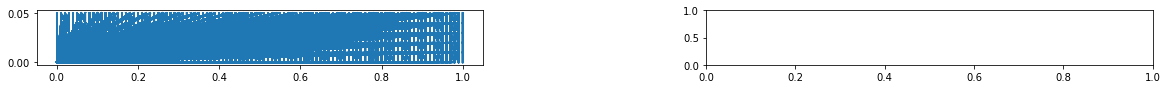

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.tri as tri

#file
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(filename)
reader.Update()  # Needed because of GetScalarRange
data = reader.GetOutput()
temperature = data.GetPointData().GetArray("ispatch")
#points
points = data.GetPoints()
npts = points.GetNumberOfPoints()
x = vtk_to_numpy(points.GetData())
triang = tri.Triangulation(x[:,0], x[:,1])
#cells
triangles=  vtk_to_numpy(data.GetCells().GetData())
ntri = triangles.size//4  # number of cells
tri = np.take(triangles,[n for n in range(triangles.size) if n%4 != 0]).reshape(ntri,3)
#plots
fig, ax = plt.subplots(ncols=2, figsize=(20,1))
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.6)
plt.subplots_adjust(wspace=0.5)
#mesh
ax[0].triplot(x[:,0], x[:,1], tri)
#ax[1].tricontourf(x[:,0], x[:,1], tri, phasefield, 12);
#contour_right = ax[1].tricontourf(triang, temperature)
#fig.colorbar(contour_right,ax=ax[1],label='$T$ / [K]')
plt.savefig("figures.png")

**Running ogs using [ogs6py](https://github.com/joergbuchwald/ogs6py)**

In [41]:
#import ogs6py
#ogs6py.__version__

In [64]:
from ogs6py import ogs
PROJECT_FILE = "AT1_iso_tensile.prj"
model = ogs.OGS(INPUT_FILE=PROJECT_FILE,PROJECT_FILE=PROJECT_FILE)
#print("PROCESS: ")
#model.tree.find("./processes/process/type").text
#print("PARAMETERS: ")
[i.text for i in model.tree.findall("./parameters/parameter/name")]
#print("PROCESS: ")
#[i.text for i in model.tree.findall("./processvars/parameter/name")]
#[i.text for i in model.tree.findall("./nonlinsolvers/parameter/name")]
#[i.text for i in model.tree.findall("./linsolvers/parameter/name")]
#[i.text for i in model.tree.findall("./parameters/parameter/name")]

['E',
 'nu',
 'k',
 'gc',
 'ls',
 'rho_sr',
 'displacement0',
 'phasefield_ic',
 'phasefield_bc',
 'dirichlet0',
 'Dirichlet_spatial',
 'dirichlet_right_time',
 'dirichlet_right']

In [65]:
import multiprocessing
from ogs6py import ogs
#run ogs
PATH_OGS = "/home/ok/ogs/build/release/bin/"
PATH_SINGULARITY = "/usr/bin/"
PATH_CONTAINER = "/home/ok/ogs/container/gcc-10-openmpi-4.0.5-system-cmake-f0a156cb-4a3437aac8bc.sif"
PROJECT_FILE = "AT1_iso_tensile.prj"
print("===============")
print(">>> run ogs <<<")
model = ogs.OGS(INPUT_FILE=PROJECT_FILE,PROJECT_FILE=PROJECT_FILE)
model.geo.add_geom(filename="bar.gml")
model.mesh.add_mesh(filename="bar.vtu")
model.mesh.add_mesh(filename="bar_left.vtu")
model.mesh.add_mesh(filename="bar_right.vtu")
#model.run_model?
#model.run_model(path=PATH_OGS,logfile="console.log")
#model.run_model(path=PATH_SINGULARITY,container_path=PATH_CONTAINER,logfile="console.log")
# listing model as process for parallel processing
ogs_process = multiprocessing.Process(
    target=model.run_model,
    kwargs={"path":PATH_SINGULARITY, "container_path":PATH_CONTAINER,"logfile":"example.log"})
# start of ogs in background
ogs_process.start()
print(">>> ogs is running in background <<<")

>>> run ogs <<<
>>> ogs is running in background <<<
OGS finished with project file AT1_iso_tensile.prj.
Execution took 27.632313013076782 s


In [5]:
#for running ogs in the jupyter container
#!ogs AT1_iso_tensile.prj

info: This is OpenGeoSys-6 version 6.4.1-200-gc33c20aba.
info: OGS started on 2021-11-16 00:59:16+0100.
[0] info: ConstantParameter: E
[0] info: ConstantParameter: nu
[0] info: ConstantParameter: k
[0] info: ConstantParameter: gc
[0] info: ConstantParameter: ls
[0] info: ConstantParameter: rho_sr
[0] info: ConstantParameter: displacement0
[0] info: ConstantParameter: phasefield_ic
[0] info: ConstantParameter: phasefield_bc
[0] info: ConstantParameter: dirichlet0
[0] info: ConstantParameter: Dirichlet_spatial
[0] info: CurveScaledParameter: dirichlet_right_time
[0] info: ConstantParameter: dirichlet_right
[0] info: No source terms for process variable 'phasefield' found.
[0] info: No source terms for process variable 'displacement' found.
[0] warning: Secondary variable type specification is deprecated and is ignored. All secondary variable types are 'static'.
[0] warning: Secondary variable type specification is deprecated and is ignored. All secondary variable types are 'static'.
[0] 

**Extracting results using [VTUInterface](https://github.com/joergbuchwald/VTUinterface)**

In [6]:
# read and process (point interpolation) vtu- and pvd-files 
import vtuIO
import matplotlib.tri as tri
print("=====================")
print(">>> print results <<<")
pvdfile=vtuIO.PVDIO("./AT1_iso_tension.pvd", dim=3)
xaxis =  [(i,0,0) for i in np.linspace(start=0.0, stop=1.0, num=100)]
r_x = np.array(xaxis)[:,0]
time = [0.0]
for t in time:
    function_xaxis_t = pvdfile.read_point_set_data(t, 'phasefield', pointsetarray=xaxis)
    plt.plot(r_x, function_xaxis_t, label='t='+str(t))
# plot formatting
titlestring="TH process: FEBEX type repository"
plt.title(titlestring)
#plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.legend()
plt.grid()
plt.savefig("profile.png")
plt.show()

ERROR:root:Cannot find UnstructuredGrid element in file.
ERROR:root:Algorithm vtkXMLUnstructuredGridReader(0x33d6910) returned failure for request: vtkInformation (0x33d5c60)


>>> print results <<<
./AT1_iso_tension.pvd


AttributeError: 'NoneType' object has no attribute 'GetData'

**Vertical cross-sections**

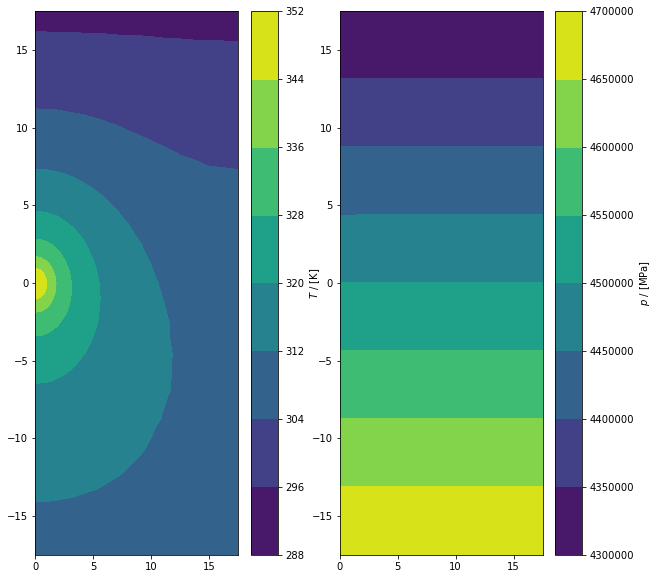

In [7]:
m_plot=vtuIO.VTUIO("th_decovalex_ts_30_t_8.000000.vtu", dim=2)
triang=tri.Triangulation(m_plot.points[:,0],m_plot.points[:,1])
u_plot = m_plot.get_point_field("T")
p_plot = m_plot.get_point_field("p")
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
contour_left = ax[0].tricontourf(triang, u_plot)
contour_right = ax[1].tricontourf(triang, p_plot)
fig.colorbar(contour_left,ax=ax[0],label='$T$ / [K]')
fig.colorbar(contour_right,ax=ax[1],label='$p$ / [MPa]')
plt.show()

In [8]:
import time
print(time.ctime())

Wed Nov  3 21:37:20 2021


**Results have been shown using [matplotlib](https://matplotlib.org/)**

**OGS links**
- description: https://www.opengeosys.org/docs/benchmarks/hydro-thermal/decovalex-th/
- project file: https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/HT/StaggeredCoupling/ADecovalexTHMCBasedHTExample/th_decovalex.prj

**Credits**
- Jörg Buchwald for [ogs6py](https://github.com/joergbuchwald/ogs6py) and [VTUInterface](https://github.com/joergbuchwald/VTUinterface)
- Wenqing and Jörg for this benchmark set up
- Pierre Navaro for providing code https://perso.univ-rennes1.fr/pierre.navaro/read-vtk-with-python.html